<h1>DEEP-EMOTIVE</h1>
<h2>Trabalho de conclusão de curso - Ciência da Computação  - FURB - 2017</h2>
<h3>Autor: Diogenes Ademir Domingos<br>
 Modulo de transferência de aprendizado<br>
 Base de dados Japanese Female Facial Expression (JAFFE)</h3>

<p>Deep-Emotive é um protótipo para reconhecer e classificar as expressões faciais das emoções, alegria, desgosto, medo, raiva, surpresa, tristeza, consideradas por Ekman et al. (1987), como básicas e universais, utilizando técnicas já consolidadas das áreas de Processamento Digital de Imagem e Visão Computacional. Estas técnicas são combinadas com uma nova abordagem, considerada a mais avançada no reconhecimento visual de objetos através do aprendizado de máquina, o Aprendizado Profundo ou Deep Learning.</p>

<p>A transferência de aprendizado consiste em utilizar um conhecimento adquirido na resolução de um problema e aplicá-lo a um novo problema relacionado a este.A base de dados JAFFE, criada por LYONS et al., 1998, possui um total de 213 amostras de sessenta mulheres japonesas.As amostras desta base de dados estão distribuídas em: 31 imagens com expressões de alegria; 29 de desgosto; 32 de medo; 30 neutras; 30 de raiva; 30 de surpresa; e 31 de tristeza. Esta base de dados se enquadra na primeira categoria de transferência de aprendizado, pois ela é pequena e bem similar à base de dados utilizada para treinamento da rede DeepEmotive.</p>

<p>Os resultados obtidos foram satisfatórios quando aplicado a transferência de aprendizado na base de dados JAFFE, atingindo uma precisão de 93,02%. </p>

In [1]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import pandas as pd
import itertools
import csv

# Modulo para trabalhar com de coleções em forma de dicionarios
from collections import OrderedDict

# Referência: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
from mpl_toolkits.axes_grid1 import make_axes_locatable

# biblioteca para trabalhar com imagens
from PIL import Image, ImageEnhance

# Scikitlearn
from sklearn.utils import shuffle
#from sklearn.cross_validation import train_test_split #cross_validation is deprecated

# Configunrando o framework Keras.

# Importando o modelo do Keras (https://keras.io/getting-started/sequential-model-guide/)
from keras.models import Sequential

# Importando modelo para salvar e importar a DNN
from keras.models import model_from_json, load_model

# Importando o tipo de camada
from keras.layers import Input,Dense

from keras.layers import merge

# Importando modulo de Dropout da rede, para aplicar mutações.
from keras.layers import Dropout

# Importando modulo de achatamento dos vetores.
# Aprimora a entrada. Não afeta o tamanho do lote.
# (https://keras.io/layers/core/#flatten)
from keras.layers import Flatten

# Importando modulo para explrar as camadas do modelo
from keras.models import Model

# Importanto modulo de convolução (https://keras.io/layers/convolutional/)
from keras.layers.convolutional import Conv2D

# Importando modulo para trabalhar com as bordas da imagem (https://keras.io/layers/convolutional/#zeropadding2d)
from keras.layers.convolutional import ZeroPadding2D

# Importando modulo para normalizar a imagem (https://keras.io/layers/convolutional/#zeropadding2d)
from keras.layers.normalization import BatchNormalization

# Importando modulo de subamostragem (https://keras.io/layers/pooling/)
from keras.layers.convolutional import MaxPooling2D

from keras.layers.pooling import AveragePooling2D

# Importando Lib de utilidades (https://keras.io/utils/)
from keras.utils import np_utils

# Importante modulo de trabalho em backend (Th ou Tf) (https://keras.io/backend/)
from keras import backend as K

# modulo para trabalhar reprocessar as imagens
from keras.preprocessing import image

# modulo de utilizades para trabalhar reprocessar as imagens
from keras.utils.data_utils import get_file

# modulo de callback para parar o treinamento na melhor opção
from keras.callbacks import EarlyStopping, ModelCheckpoint

# fine tunnig
from keras import optimizers

# ativadores avançados
from keras.layers.advanced_activations import LeakyReLU, PReLU

# Modulo Scikit-Learn para montar a matriz de confusão
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

#import theano
#import keras_mnist_vis 
#K.set_image_dim_ordering('th')

# permitindo mais de um print por saída
from __future__ import print_function

# para criação do dataset em x_train, x teste
from sklearn.model_selection import train_test_split

# modulo do sistema operacional
import os

# Dimensões da imagem
# img_rows, img_cols = 640, 490 <--- TAMANHO NORMAL
img_rows, img_cols = 98, 98 #<--- # TESTES
#img_rows, img_cols = 224, 224 #<--- # TESTES
#img_rows, img_cols = 80, 60 # TESTES

# números de canais(RGB)
img_channels = 1

# Configurando o plot para ser inline ao inves de outra janela.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # padronizando tamanho plot
plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray' # padronizndo color map
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


<h1>Pré-processamento</h1>
<p>A fase de pré-processamento é responsável pela aplicação de transformações nas imagens importadas para o protótipo, redimensionando cada imagem para uma dimensão prédefinida de 98 pixels largura e 98 pixels de altura. Não é aplicado a técnica Data Augmentation na fase de transferência de aprendizado</p>

In [2]:
path = './transfer learning/jaffeimages/faces-jaffe'

In [3]:
classes_emocoes = ['raiva','desgosto','medo','alegria','neutra','tristeza','surpresa']
num_emocoes = len(classes_emocoes)
print("Quantidade de emoções: ",num_emocoes)
print(classes_emocoes)

Quantidade de emoções:  7
['raiva', 'desgosto', 'medo', 'alegria', 'neutra', 'tristeza', 'surpresa']


In [6]:
def identificar_emocao(filename):
    """ Esta função é responsável por criar as categorias
        de emoção. As cateforias estão descritas no nome do
        arquivo. Recebe como o nome do arquivo e retorna
        a categoria de emoção que ele pertence

        Args:
            filename (PIL): nome do arquivo contendo a emoção

        Returns:
            int: inteiro representando a posição da emoção na lista
    """
    #['raiva', 'desgosto', 'medo', 'alegria', 'neutra', 'tristeza', 'surpresa']
    em = filename.split('.')
    if em[1][:2] == "AN":
        return 0
    elif em[1][:2] == "DI":
        return 1
    elif em[1][:2] == "FE":
        return 2
    elif em[1][:2] == "HA":
        return 3
    elif em[1][:2] == "NE":
        return 4
    elif em[1][:2] == "SA":
        return 5
    elif em[1][:2] == "SU":
        return 6

In [7]:
def carregar_imagens(path):
    """ Esta função é responsável por importar as imagens para 
        o protótipo. Recebe caminho do diretório onde as imagens 
        estão localizadas. Retorna uma lista de tuplas de duas 
        posições. A primeira posição é o objeto de imagem e a 
        segunda é a emoção da imagem.

        Args:
            path (string): caminho do diretório onde as imagens 
            estão localizadas.
        Returns:
            tuple (len=2): tupla contendo objeto imagem e emoção.
    """  
    imagens = [] # lista para guardar as faces segmentadas
    files = [f for f in os.listdir(path)]
    print('Carregando imagens...')
    # para cada imagem
    for file in files:
        # Abrir imagem para normalizar o tamanho
        img = Image.open(path + '\\' + file)
        # normalizar o tamanho
        img = img.resize((img_rows,img_cols), Image.ANTIALIAS)
        # coverte imagem para escala de cinza.
        img_gray = img.convert('L') 
        # salva instancia da imagem no array de dados
        # salva também qual a categoria que a imagem pertence
        #classes_emocoes = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
        imagens.append((img_gray, identificar_emocao(file)))

    print('Imagens carregadas com sucesso!')
    print('Quantidade de imagens: ',len(imagens))
    return imagens

In [8]:
imagens = carregar_imagens(path)

Carregando imagens...
Imagens carregadas com sucesso!
Quantidade de imagens:  213


In [9]:
# verificando qunatidade de imagens para trabalhar
qtd_imagens = len(imagens) # get the number of images
print('Quantidade de imagens para trabalhar: ',qtd_imagens)

# iniciando acesso as imagens
# como esta repersentado a imagem = tupla(imagem, categoria)
print('Representação da lista de imagem: ',imagens[0])

Quantidade de imagens para trabalhar:  213
Representação da lista de imagem:  (<PIL.Image.Image image mode=L size=98x98 at 0x2ABF4DCBE10>, 0)


In [10]:
# Verificando a distribuição da base de dados
#classes_emocoes = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
def qtd_por_emocao(imagens):
    raiva = [x for x in imagens if x[1] == 0]
    desgosto = [x for x in imagens if x[1] == 1]
    medo = [x for x in imagens if x[1] == 2]
    alegria = [x for x in imagens if x[1] == 3]
    neutral = [x for x in imagens if x[1] == 4]
    tristeza = [x for x in imagens if x[1] == 5]
    surpresa = [x for x in imagens if x[1] == 6]
    print("Raiva:",len(raiva), "- Desgosto:",len(desgosto), "- Medo:",len(medo), "- Alegria:",len(alegria), "- Neutra:",len(neutral), "- Tristeza:",len(tristeza), "- Surpresa:",len(surpresa))
    return len(raiva), len(desgosto), len(medo), len(alegria), len(neutral), len(tristeza), len(surpresa)

Raiva: 30 - Desgosto: 29 - Medo: 32 - Alegria: 31 - Neutra: 30 - Tristeza: 31 - Surpresa: 30


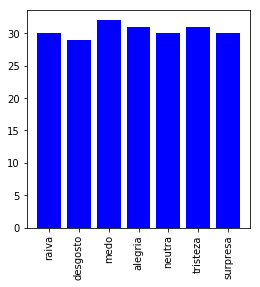

In [11]:
# Visualizando a distribuição por categoria de emoção
def visualiza_distribuicao():
    dist_y = qtd_por_emocao(imagens)
    dist_x = np.arange(num_emocoes)
    x_label = classes_emocoes
    fig,ax = plt.subplots(figsize=(4,4))
    ax.bar(dist_x, dist_y, width=0.8, color='blue')
    ax.set_xticks(dist_x)
    ax.set_xticklabels(x_label, rotation=90)
    plt.show()
    
visualiza_distribuicao()

<h1>Preparar dados para treinamento</h1><br>
<p>A etapa preparar dados, é responsável por preparar o conjunto de dados para o treinamento, para que seja possível sua utilização pelo framework de aprendizado profundo.</p>

Formato da imagem: (98, 98)


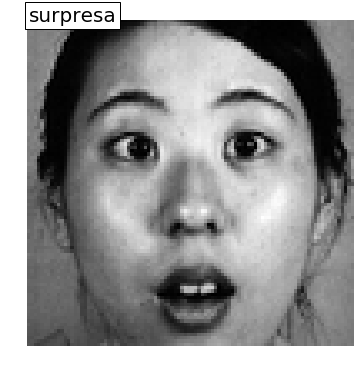

In [12]:
# Seleciona uma imagem aleatoria
idx_img_aleatoria = random.randint(0, qtd_imagens)
img_aleatoria, emocao_aleatoria = imagens[idx_img_aleatoria][0], imagens[idx_img_aleatoria][1]
#print(img_aleatoria.size)
print("Formato da imagem: {}".format(np.array(img_aleatoria).T.shape))

# Visualizar a imagem aleatoria
plt.figure(figsize=(6,6))
plt.imshow(img_aleatoria, cmap='gray')
plt.text(0, 0, classes_emocoes[emocao_aleatoria], color='black', 
           bbox=dict(facecolor='white', alpha=1),fontsize=20)
plt.axis('off')
plt.show()

<h3>Extrair dados</h3>

In [13]:
# Função auxiliar para extrair os pixels da imagem
def _get_pixels_imagem(imagem, shape=(img_cols,img_rows)):
    """ Esta função é responsável por extrair os pixels 
        da imagem. Recebe como entrada uma objeto de imagem 
        python e retorna um numpy array contendo uma 
        lista de lista de todos os pixels. Pode ser
        alterado a dimensão da imagem pelo parametro shape.

        Args:
            imagem (PIL): objeto de imagem python.
            shape (tuple): tupla contendo o dimensão
            da imagem de saida.

        Returns:
            array (np.ndarray): retorna um array numpy.
    """
    # cria uma array numpy com uma lista contendo
    # todos os pixels da imagem
    pixel_values = np.array(list(imagem.getdata()))
    
    # redimensiona os pixels para formato 98x98
    pixel_values = pixel_values.reshape(shape)
    return pixel_values

Formato da array de pixels: (98, 98)


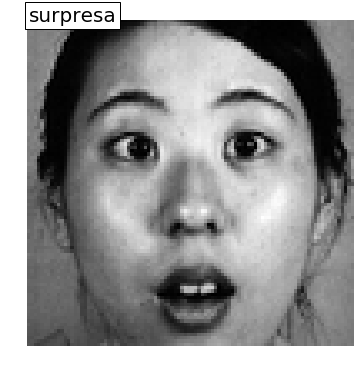

In [14]:
#Conferindo a extração dos pixels e remomtando a imagem

array_pixels = _get_pixels_imagem(img_aleatoria)
print("Formato da array de pixels: {}".format((array_pixels.shape)))

plt.figure(figsize=(6,6))
plt.imshow(array_pixels, cmap='gray')
plt.text(0, 0, classes_emocoes[emocao_aleatoria], color='black', 
           bbox=dict(facecolor='white', alpha=1),fontsize=20)
plt.axis('off')
plt.show()

In [15]:
# extrair os pixels das imagems
def extrair_dados(imagens):
    """ Esta função é responsável por extrair os pixels de 
        todas as imagem da base de dados.
        Recebe como entrada uma lista de objeto de
        imagem python e retorna uma lista de 
        numpy.ndarray contendo todos os pixels
        de todas as imagens.

        Args:
            imagens (list): lista objeto de imagem python.

        Returns:
            array (np.ndarray): retorna uma array numpay.
    """
    data = [] # para armazenar os dados
    array_emocoes = [] # para armazenar os descritores
    
    print("Extraindo os dados...")
    # para cada imagem
    for imagem in range(len(imagens)):
        # extrai o array de pixels da imagem
        data.append(_get_pixels_imagem(imagens[imagem][0]))
        # extrai a emocao que já estava definida na tupla
        array_emocoes.append(imagens[imagem][1])

    print("Quantidade de imagens extraidas:",len(data))
    print("Quantidade de emocoes extraidas:",len(array_emocoes))
    print("Extração de pixels completa!")
    return data, array_emocoes

In [16]:
# empilhar dados para trabalhar com o framework
data, array_emocoes = extrair_dados(imagens)

Extraindo os dados...
Quantidade de imagens extraidas: 213
Quantidade de emocoes extraidas: 213
Extração de pixels completa!


<h3>Empilhar dados</h3>

In [17]:
# Função que empilha o conjunto de dados,
# em formato de tupla para trabalhar com o deep learning
def empilhar_dados(dados):
    """ Esta função é responsável por empilhar os dados 
        para o formato que exigido para trabalho com o 
        framework Keras. Recebe como entrada lista de 
        dados e retorna uma tupla contendo a 
        quantidade de dados, dimensão x, e dimensão y.

        Args:
            dados (list): lista de dados.

        Returns:
            tuple: retorna uma tupla com 
            (quantidade, largura, altura).
    """
    print("Empilhando conjunto de dados:(quantidade, largura, altura)...")
    # faz uso da fucionalidade numpy de empilhamento
    dados_empilhados = np.stack(dados) 
    print("novo formato dos dados:", dados_empilhados.shape)
    return dados_empilhados

In [18]:
# empilhar imagens
print('Empilhando imagens...')
data = empilhar_dados(data)

print('Empilhando descritores de emoção...')
# empilhar descritores de emoção
labels = empilhar_dados(array_emocoes)

print("Fase de empilhamento completa!")

Empilhando imagens...
Empilhando conjunto de dados:(quantidade, largura, altura)...
novo formato dos dados: (213, 98, 98)
Empilhando descritores de emoção...
Empilhando conjunto de dados:(quantidade, largura, altura)...
novo formato dos dados: (213,)
Fase de empilhamento completa!


In [19]:
# Conferindo os pixels da imagem a partir dos dados estraidos.
print("Formato dos dados: {}".format(data[0].shape))
display(pd.DataFrame(data[0]))

Formato dos dados: (98, 98)


,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,39,1,3,5,2,2,6,1,4,3,...,2,3,5,3,2,0,5,7,5,4
1,9,6,3,2,1,1,1,3,2,0,...,1,2,4,2,5,3,1,5,3,8
2,3,3,1,3,0,2,2,2,5,0,...,2,2,2,3,3,5,2,4,4,39
3,3,2,3,10,2,2,4,4,4,1,...,3,2,3,2,3,3,0,5,4,11
4,3,4,0,7,2,3,1,2,2,3,...,2,1,5,2,2,2,1,1,5,4
5,5,4,4,1,4,3,3,2,4,2,...,5,3,4,3,4,1,1,5,5,4
6,3,3,1,3,6,4,5,6,1,2,...,5,4,6,3,4,3,2,6,5,5
7,4,2,2,3,1,3,6,3,4,3,...,2,3,3,2,2,3,2,1,4,2
8,4,1,2,4,6,5,3,2,5,3,...,3,4,3,3,7,4,1,7,3,1
9,4,4,1,3,2,2,5,1,2,5,...,3,3,3,3,3,4,4,9,2,1


Formato da imagem: (98, 98)


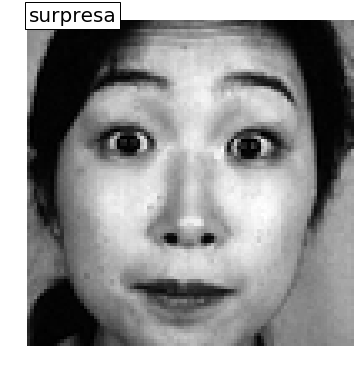

In [20]:
# Seleciona uma imagem aleatoria
idx_img_aleatoria = random.randint(0, qtd_imagens)
img_aleatoria, emocao_aleatoria = imagens[idx_img_aleatoria][0], imagens[idx_img_aleatoria][1]
#print(img_aleatoria.size)
print("Formato da imagem: {}".format(np.array(img_aleatoria).T.shape))

plt.figure(figsize=(6,6))
plt.imshow(img_aleatoria, cmap='gray')
plt.text(0, 0, classes_emocoes[emocao_aleatoria], color='black', 
           bbox=dict(facecolor='white', alpha=1),fontsize=20)
plt.axis('off')
plt.show()

In [21]:
# organizando dados para trabalhar com o keras
(X, y) = (data, labels)

In [22]:
# backup para plot na predição
print('Criando backup dos dados...')
X_test_orig = X
Y_test_orig = y
print('Backup - Estrutura do dados: ',X_test_orig.shape)
print('Backup - labels: ',len(Y_test_orig))
print('Backup completo!')

Criando backup dos dados...
Backup - Estrutura do dados:  (213, 98, 98)
Backup - labels:  213
Backup completo!


In [23]:
def amostragem(quantidade, limite):
    fig = plt.figure(figsize=(16,16))
    for i in range(quantidade):
        idx = random.randint(0,limite-1),
        input_img = X_test_orig[idx[0]].reshape(img_cols, img_rows)
        ax = fig.add_subplot(10,10,i+1)
        ax.imshow(input_img, interpolation='nearest', cmap='gray')
        idx_emocao = idx[0]
        plt.text(0, 0, classes_emocoes[Y_test_orig[idx_emocao]], color='black', 
           bbox=dict(facecolor='white', alpha=1),fontsize=20)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()

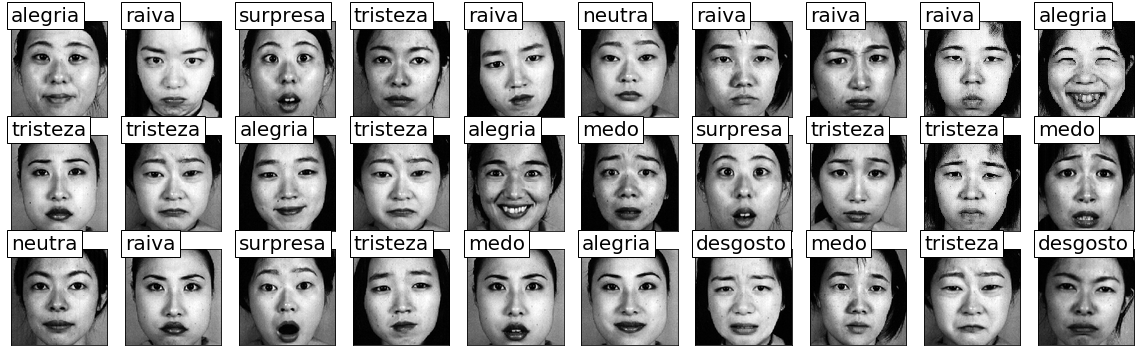

In [24]:
# Visualizando amostra dos dados
amosta = 30
amostragem(amosta, len(X_test_orig))

<h3>Separar dados</h3>

In [25]:
# Separando os dados para treinamento
def separar_treino_e_teste(imagens, descritores):
    """ Esta função é responsável por separa os dados 
        em conjunto de treino e teste. Recebe como 
        entrada tupla contendo todos os dados da 
        imagens e uma tupla contendo os descritores. 
        Retorna uma tupla contendo imagens de treino,
        descritores de treino, imagens de teste e 
        descritores de teste.

        Args:
            imagens (tuple): tupla de dados .

        Returns:
            tuple: tupla contendo dados de treino, dados de teste. 
    """
    # test_size=0.2 = percentual de separação 20% para teste
    # random_state = definindo a semente para escolha aleatoria
    print('Separando os dados em grupo de treino e teste...')
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                    test_size=0.2, random_state= int(qtd_imagens))
    print('Imagens separadas para treino: ',X_train.shape)
    print('Imagens separadas para teste: ',X_test.shape)
    print('Emoções separadas para treino: ',y_train.shape)
    print('Emoções separadas para teste: ',y_test.shape)
    return X_train, X_test, y_train, y_test

In [26]:
X_train, X_test, y_train, y_test = separar_treino_e_teste(X, y)

Separando os dados em grupo de treino e teste...
Imagens separadas para treino:  (170, 98, 98)
Imagens separadas para teste:  (43, 98, 98)
Emoções separadas para treino:  (170,)
Emoções separadas para teste:  (43,)


<h3>Formatar dados</h3>

In [27]:
# configura shape, adicionando a camanda de cor
# Shape é configurado de acordo com framework de background: tensorflow(tf) ou Theano(th)
def formatar_shape(X_train, X_test, canais=1):
    """ Esta função é responsável por formatar os dados
        para trabalhar com o deep learning, de acordo com
        o framework que está em background (tensorflow(tf) 
        ou Theano(th)).
        Recebe como parametro a quantidade de canais de cor
        que as imagens possuem.
        
        Args:
            X_train (tuple): imagens de treinamento
            X_train (tuple): imagens de teste
            canais (int): quantidade de canais de profundidade.
        Returns:
            tuple: tupla contendo dados de treino, dados de teste,
            e o shape dos dados, formatados para deep learning. 
    """
    print("Adicionando canais de cores na estrutura de dados...")
    # O framework theano trabalha com a quantidade de canais 
    # de cores a frente da dimesão da imagem
    if K.image_data_format() == 'channels_first': # = th
        shape = (canais, img_cols, img_rows)
        #shape = (1, img_cols, img_rows)
        print("Trabalhando com theano:", shape)
    # O framework tensorflow trabalha com a quantidade de canais
    # de cores apos a dimesão da imagem
    else:  # channel_last = tf
        shape = (img_cols, img_rows, canais)
        #shape = (img_cols, img_rows, 1)
        print("Trabalhando com tensorflow:",shape)
    print("Novo formato para estrutura de dados contendo o canal de cor: ",shape)
    print('Alterando o formato das imagens, colocando a estrutura com canal de cor...')
    X_train = X_train.reshape((X_train.shape[0],) + shape).astype('float32')
    X_test = X_test.reshape((X_test.shape[0],) + shape).astype('float32')
    print('Novo formato das imagens separadas para treino: ',X_train.shape)
    print('Novo formato das imagens separadas para teste: ',X_test.shape)
    # cada pixels é normalizado = pixel = pixel / 255
    print('Normalizando os dados...')
    X_train /= 255
    X_test /= 255
    return X_train, X_test, shape

In [28]:
X_train, X_test, shape = formatar_shape(X_train, X_test)

Adicionando canais de cores na estrutura de dados...
Trabalhando com tensorflow: (98, 98, 1)
Novo formato para estrutura de dados contendo o canal de cor:  (98, 98, 1)
Alterando o formato das imagens, colocando a estrutura com canal de cor...
Novo formato das imagens separadas para treino:  (170, 98, 98, 1)
Novo formato das imagens separadas para teste:  (43, 98, 98, 1)
Normalizando os dados...


<h3>Criar matriz one-hot</h3>

In [29]:
# Criando a classificação
# Converte um vetor de classe (inteiros) em matriz de classe verdade (binária).
def criar_matriz_verdade(y_train, y_test):
    """ Esta função é responsável por criar uma matriz
        verdade para todos os descritores do conjunto de dados.
        Recebe como parametro os descritores de treino e teste.
        
        Args:
            Y_train (tuple): descritores de emoção de treinamento
            Y_test (tuple): descritores de emoção de teste 
        
        Returns:
            tuple: tupla contendo as matrizes verdade dos
            descritores de treino, dados de teste,
    """
    print('Criando a matriz de classificação binária...')
    # Classificando os descritores de treino
    Y_train = np_utils.to_categorical(y_train)
    # Classificando os descritores de teste
    Y_test = np_utils.to_categorical(y_test)

    # verificando a quantidade de classes encontradas
    n_treino = Y_train.shape[1]
    print('Classes encontradas para imagens: ', n_treino)

    # verificando a quantidade de classes encontradas
    n__teste = Y_test.shape[1]
    print('Classes encontradas para emocoes: ', n__teste)
    return Y_train, Y_test

In [30]:
Y_train, Y_test = criar_matriz_verdade(y_train, y_test)

Criando a matriz de classificação binária...
Classes encontradas para imagens:  7
Classes encontradas para emocoes:  7


In [31]:
# visualizando matriz verdade
print(Y_train[:5])
print(Y_train.shape)
print(Y_test[:5])
print(Y_test.shape)

[[ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]]
(170, 7)
[[ 1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]]
(43, 7)


<h1>Importar rede neural profunda</h1>
<p>Nesta etapa do desenvolvimento é importado a arquitetura da rede neural treinada anteriormente.
A rede neural profunda, utilizada neste protótipo possui a arquitetura ilustrada na figura abaixo.</p>

In [32]:
display(HTML('''<img src="./util/Diagrama - Arquitetura da rede neural -FINAL.png">'''))

In [33]:
MODELO_SALVO_JSON = './deep_emotive_model_t10_faces.json'
MELHOR_PESO = './pesos/pesos_teste_10-266-0.96.3.hdf5'

In [34]:
# Carregando o modelo salvo
# Lendo o modelo salvo em arquivo para um novo modelo
print("Carregando o modelo...")
json_file = open(MODELO_SALVO_JSON, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
print('Modelo carregado com sucesso!')

Carregando o modelo...
Modelo carregado com sucesso!


In [35]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Bl01_Conv (Conv2D)           (None, 98, 98, 64)        1664      
_________________________________________________________________
Bl01_PReLU (PReLU)           (None, 98, 98, 64)        614656    
_________________________________________________________________
Bl01_Pooling (AveragePooling (None, 49, 49, 64)        0         
_________________________________________________________________
Bl02_Conv (Conv2D)           (None, 45, 45, 128)       204928    
_________________________________________________________________
Bl02_PRelu (PReLU)           (None, 45, 45, 128)       259200    
_________________________________________________________________
Bl02_Pooling (AveragePooling (None, 22, 22, 128)       0         
_________________________________________________________________
Bl03_Conv (Conv2D)           (None, 18, 18, 256)       819456    
__________

In [36]:
# Carregando o melhor pesos do checkout para para o novo modelo
print("Carregando os melhores pesos...")
loaded_model.load_weights(MELHOR_PESO)

# Compilando o modelo que estava salvo
# lr: taxa de aprendizado
# decay: tamanho do passo da caída do gradiente
adam = optimizers.Adam(lr=1e-3, decay=1e-5)    

# Copilando o modelo
# Função de apredizado será cross-entropy (https://en.wikipedia.org/wiki/Cross_entropy)
# métrica de reconhecimento será precisão.
loaded_model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
print("Carregamento dos melhores pesos completo!")

Carregando os melhores pesos...
Carregamento dos melhores pesos completo!


In [37]:
def alterar_ultima_camada(model, classes_emocoes, nome='Classi_Densa2'):
    """ Esta função é responsável por alterar a
        ultima camada da rede original. Recebe o modelo
        original, remove a ultima camada, adiciona uma
        nova camada com a nova qunatidade de emoções na saída.
        Retorna novo modelo alterado
        
        Args:
            model (model): rede original
            classes_emocoes (int): quantidade de emoções para classificar
            nome (string): idenficador para nova camada
        
        Returns:
            model: novo modelo de rede, como a ultima camada alterada
    """
    # remove a ultima camanda
    model.pop()
    # adiciona nova camada configurando a quantidade de classes
    model.add(Dense(len(classes_emocoes), activation='softmax',name=nome))
    adam = optimizers.Adam(lr=1e-3, decay=1e-5)    

    # Copilando o modelo
    # Função de apredizado será cross-entropy (https://en.wikipedia.org/wiki/Cross_entropy)
    # métrica de reconhecimento será precisão.
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

In [38]:
# alterar ultima camada
loaded_model = alterar_ultima_camada(loaded_model, classes_emocoes)
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Bl01_Conv (Conv2D)           (None, 98, 98, 64)        1664      
_________________________________________________________________
Bl01_PReLU (PReLU)           (None, 98, 98, 64)        614656    
_________________________________________________________________
Bl01_Pooling (AveragePooling (None, 49, 49, 64)        0         
_________________________________________________________________
Bl02_Conv (Conv2D)           (None, 45, 45, 128)       204928    
_________________________________________________________________
Bl02_PRelu (PReLU)           (None, 45, 45, 128)       259200    
_________________________________________________________________
Bl02_Pooling (AveragePooling (None, 22, 22, 128)       0         
_________________________________________________________________
Bl03_Conv (Conv2D)           (None, 18, 18, 256)       819456    
__________

<h3>Configurando a transferência de aprendizado</h3>
<p>Esta base de dados se enquadra na primeira categoria de transferência de aprendizado, pois ela é pequena e bem similar à base de dados utilizada para treinamento da rede DeepEmotive.
Todas as camadas de convolução foram marcadas como não treinaveis, ou seja, os pesos não serão reajustado.
É treinado apenas a ultima camada, responsável pela classificação.</p>

In [39]:
# resetando o treino anterior
for layer in loaded_model.layers:
     layer.trainable = False

In [40]:
# Verificando camadas non-trainable
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Bl01_Conv (Conv2D)           (None, 98, 98, 64)        1664      
_________________________________________________________________
Bl01_PReLU (PReLU)           (None, 98, 98, 64)        614656    
_________________________________________________________________
Bl01_Pooling (AveragePooling (None, 49, 49, 64)        0         
_________________________________________________________________
Bl02_Conv (Conv2D)           (None, 45, 45, 128)       204928    
_________________________________________________________________
Bl02_PRelu (PReLU)           (None, 45, 45, 128)       259200    
_________________________________________________________________
Bl02_Pooling (AveragePooling (None, 22, 22, 128)       0         
_________________________________________________________________
Bl03_Conv (Conv2D)           (None, 18, 18, 256)       819456    
__________

In [41]:
# chekpoint para salvar o mehlor aprendizado enter as epocas
filepath="./pesos/checkpoint-transfer-learning-jaffe-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath,  # caminho para o modelo salvo
                             monitor= 'val_acc', # qual parametro vai acompanhar
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # sobreescreve o modelo apenas se for o melhor
                             mode='auto') # dependecia de acorco com o monitor

callback_list=[checkpoint]

In [43]:
# Treinando o modelo DNN para 01 época
# Função FIT: realiza o treinamento até uma quantidade de épocas determinada.
# parametro validation_data: Dados para avaliar a perda do gradiente ao final de cada época
# parametro batch_size: numero de amostras para atualizar a perda do gradientes
# Paramentro verbose : 0 = silent, 1 = verbose, 2 = one log line per epoch.
# %time = medindo tempo do treino
#PESOS_SALVOS = 'ck_cnn_weights_t10_faces.hdf'

MELHOR_PESO_JAFFE = './pesos/checkpoint-transfer-learning-jaffe-20-0.93.hdf5'

# Flag True ou false para retreinar a rede
if True and os.path.exists(MELHOR_PESO_JAFFE):    
    print('Carregando pesos salvos de treino anterior...')
    loaded_model.load_weights(MELHOR_PESO_JAFFE)
    # Compilando o modelo que estava salvo
    # lr: taxa de aprendizado
    # decay: tamanho do passo da caída do gradiente
    adam = optimizers.Adam(lr=1e-3, decay=1e-5)    

    # Copilando o modelo
    # Função de apredizado será cross-entropy (https://en.wikipedia.org/wiki/Cross_entropy)
    # métrica de reconhecimento será precisão.
    loaded_model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    print('Pesos carregados com sucesso!')
else:
    # treinando a DNN para 20 épocas
    #callback_list=[monitor,checkpoint]
    callback_list=[checkpoint]
    print('Treinando a DNN...')
    %time history = loaded_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), callbacks=callback_list, epochs=30, batch_size=32, verbose=1)
    print('Treinanmeto finalizado!')

Carregando pesos salvos de treino anterior...
Pesos carregados com sucesso!


In [44]:
# Avaliando a precisção do modelo carregado depois do fit

print('Metricas do Modelo: {}'.format(loaded_model.metrics_names))
loaded_model_metricas = loaded_model.evaluate(X_test, Y_test, verbose=1)
print("Erro de: %.2f%%" % (100-loaded_model_metricas[1]*100))
print("Precisão de: %.2f%%" % (loaded_model_metricas[1]*100))

Metricas do Modelo: ['loss', 'acc']
43/43 [==============================] - 2s     
Erro de: 6.98%
Precisão de: 93.02%


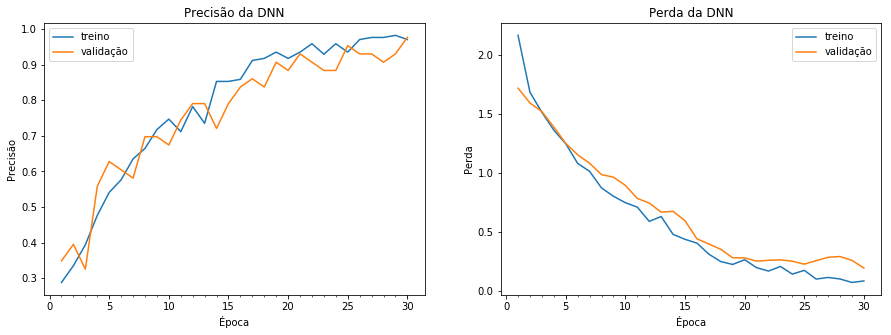

In [47]:
def plot_model(history):

    # Cria subplots
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Precisão
    axs[0].plot(range(1,len(history.history['acc'])+1),history.history['acc'])
    axs[0].plot(range(1,len(history.history['val_acc'])+1),history.history['val_acc'])
    axs[0].set_title('Precisão da DNN')
    axs[0].set_ylabel('Precisão')
    axs[0].set_xlabel('Época')
    axs[0].set_xticks(np.arange(1,len(history.history['acc'])+1),len(history.history['acc'])/10)
    axs[0].legend(['treino', 'validação'], loc='best')
    
    # Perda
    axs[1].plot(range(1,len(history.history['loss'])+1),history.history['loss'])
    axs[1].plot(range(1,len(history.history['val_loss'])+1),history.history['val_loss'])
    axs[1].set_title('Perda da DNN')
    axs[1].set_ylabel('Perda')
    axs[1].set_xlabel('Época')
    axs[1].set_xticks(np.arange(1,len(history.history['loss'])+1),len(history.history['loss'])/10)
    axs[1].legend(['treino', 'validação'], loc='best')
    
    # Visualizar
    plt.show()
        
plot_model(history)

In [53]:
# Salvando o modelo criado
print('Salvando o modelo...')
# serialize model para formato JSON
MODELO_SALVO_JAFFE = './transfer learning/jaffeimages/model-transfer-learning-jaffe.json'
model_json = loaded_model.to_json()
with open(MODELO_SALVO_JAFFE, "w") as json_file:
    json_file.write(model_json)
    print('Modelo salvo com sucesso!')

Salvando o modelo...
Modelo salvo com sucesso!


<h1>Predição</h1>
<p>A predição é a etapa final do processamento de execução do protótipo, e é responsável por apresentar a classificação de uma ou mais imagens, baseado no aprendizado adquirido pela rede, na fase de treinamento</p>

In [45]:
def predizer(model, imagens):
    """Esta função é responsável por realizar a predição 
       do conjunto de dados. Recebe como parametro o 
       modelo da rede, e retorna uma tupla contendo a 
       matriz de probabilidade e a matriz da classificação.

       Args:
           model (sequencial): modelo da rede neural
           treinado.
           imagens (list): lista contendo as imagens
           para predizer a emoção
       Returns:
           np.array: matriz de probabilidade
           np.array: matriz da classificação
    """
    print('Predição da(s) imagem(ns)...')
    m_probabilidade = model.predict(X_test, batch_size=32, verbose=1)
    m_predicao = [np.argmax(prob) for prob in m_probabilidade]
    
    print('Predição completa!')
    print('Quantidade de imagens analisadas: ', len(m_predicao))
    return m_probabilidade, m_predicao

In [46]:
y_probabilidade, predicted = predizer(loaded_model, X_test)

Predição da(s) imagem(ns)...
43/43 [==============================] - 2s     
Predição completa!
Quantidade de imagens analisadas:  43


In [47]:
# Verificando a precisão por classe
# precision= A precisão é a razão onde é o número de positivos verdadeiros e o número de falsos positivos
# recall= O recall é a razão onde é o número de positivos verdadeiros e o número de falsos negativos
# f1-score= A média harmônica ponderada da precisão e recall
# support= O suporte é o número de ocorrências de cada classe verdade

print(classification_report(np.argmax(Y_test, axis=1), predicted, target_names=classes_emocoes))

             precision    recall  f1-score   support

      raiva       0.89      0.89      0.89         9
   desgosto       1.00      0.83      0.91         6
       medo       0.75      1.00      0.86         3
    alegria       0.86      1.00      0.92         6
     neutra       1.00      1.00      1.00         8
   tristeza       1.00      0.80      0.89         5
   surpresa       1.00      1.00      1.00         6

avg / total       0.94      0.93      0.93        43



<h3>Amostras da predição</h3>
<p>Nesta etapa é ilustrado algumas imagens que foram preditas pela rede Deep-Emotive.<br>
São selecionadas trinta imagens aleatórias e preditas, o resultado é plotado.</p>

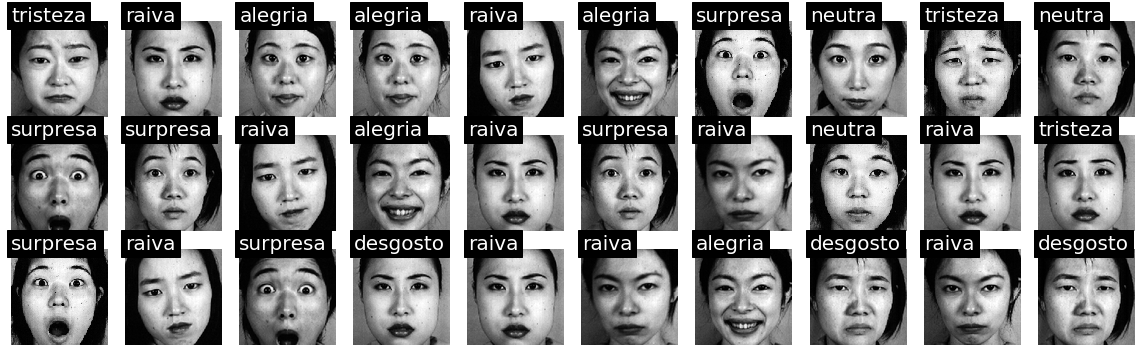

In [48]:
amosta = 30
fig = plt.figure(figsize=(16,16))
for i in range(amosta):
    #plt.subplot(1, amosta, i+1)
    # Seleciona uma imagem aleatoria
    idx_img_aleatoria = random.randint(0, len(predicted)-1)
    img_aleatoria = X_test[idx_img_aleatoria]
    
    ax = fig.add_subplot(10,10,i+1)
    # Visualiza a imagem escolhida aleatoriamente
    plt.imshow(img_aleatoria.reshape(img_cols, img_rows), interpolation='nearest', cmap='gray')

    # Visualiza o label
    plt.text(0, 0, classes_emocoes[predicted[idx_img_aleatoria]], color='white', 
             bbox=dict(facecolor='black', alpha=1), fontsize=20)
        
    plt.axis('off')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.tight_layout()
plt.show()

In [49]:
# Função para matriz de confusão da predição

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusão',
                          cmap=plt.cm.Wistia):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Base de teste')
    plt.xlabel('Predições')

Verificando quantidade de imagens da predição: 43
Verificando formato dos dados de testes: (43,)


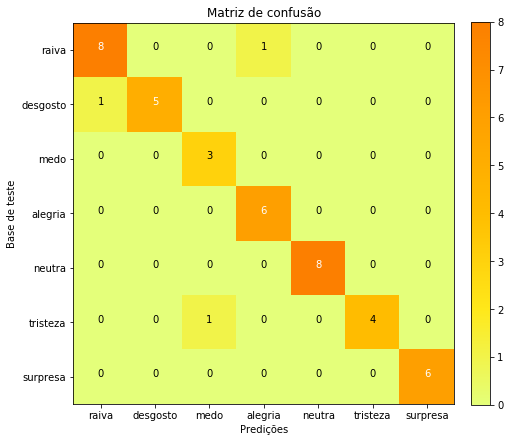

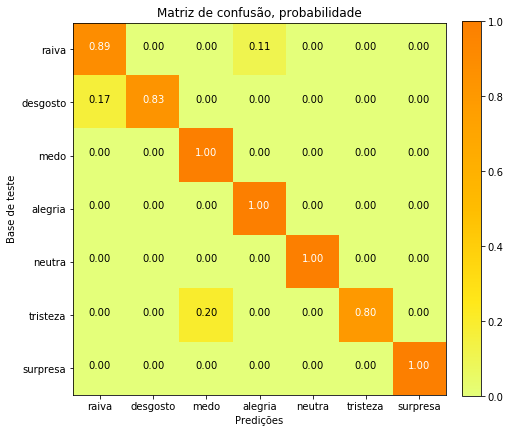

In [50]:
# Visualizando matriz de confusão da predição
#classes = ['alegria', 'desgosto', 'desprezo', 'medo', 'neutral', 'raiva', 'surpresa', 'tristeza']
# Precisa ter o mesmo formato
print('Verificando quantidade de imagens da predição: {}'.format(len(predicted)))
print('Verificando formato dos dados de testes: {}'.format(y_test.shape))


cnf_matrix = confusion_matrix(np.argmax(Y_test, axis=1), predicted)
np.set_printoptions(precision=2)

# Visualizando a matriz de confusão sem normalização.
# mosta a quantidade de imagens classificadas para cada label
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=classes_emocoes,
                      title='Matriz de confusão')

# Visualizando a matriz de confusão com normalização.
# mosta a precisão para cada label classificado
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=classes_emocoes, normalize=True,
                      title='Matriz de confusão, probabilidade')

plt.show()